# Are spatial patterns of winter radar backscatter driven by snow quantity? Does winter radar backscatter correlate with snow depth and SWE? 

> ### To see if snow depth and SWE influenced radar back scatter, we compared backscatter to airborne LiDAR-derived snow depth and snow water equivalent modeled by Airborne Snow Observatory.

### Part 1: Does snow depth influence backscatter?

* SWESARR radar was collected on February 11, 2020 and February 12, 2020
* We aimed to leverage a snowdepth raster that was collected as close to the above dates as possible. Therefore, we selected LiDAR   collected on February 13, 2020

#### The workflow is as follows:

1. Download and prepare data. We need the LiDAR and SWESARR datasets' resolution and CRS to match, and we need to clip the LiDAR to the SWESARR domain.
2. Determine and AOI within the SWESARR domain, and sample LiDAR and SWESARR at random points.
3. Use simple regression to assess correlations between LiDAR and SWESARR. 

In [1]:
#Install necessary packages for data download, transformations, and visualization 

from snowexsql.api import PointMeasurements, LayerMeasurements, RasterMeasurements
from datetime import datetime 
import rasterio 
import rioxarray as rio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import fiona
import xarray
import pandas as pd
from pyproj import CRS
import os 
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, Point, Polygon

#Store SWESARR file path as a variable
swesarr_file_path= "/home/jovyan/shared-public/swesarr project!/swesarr-radar/GRMST1_27702_20007_009_200211_225_XX_01/GRMST1_27702_20007_009_200211_09225VV_XX_01.tif"

#### We will query a LiDAR dataset from the SnowEx Database using the `snowexsql.api` package. 

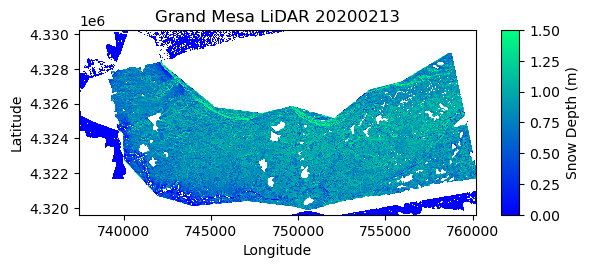

In [2]:
# Store LiDAR date as a variable
dt = datetime(2020, 2, 13)

# Query SnowEx filtering to swe on a certain date surveyed by ASO
ds = RasterMeasurements.from_filter(observers='ASO Inc.', date=dt, type='depth')

#Plot LiDAR data. Constrain min and max values so that color ramp is not washed out by variables.

# Create the raster plot
dataset = ds[0]  # Access the DatasetReader

# Read the first band into a NumPy array
raster_data = dataset.read(1)
# Get the affine transform
transform = dataset.transform

#Build extent with transform
extent = (transform[2], 
          transform[2] + dataset.width * transform[0], 
          transform[5] + dataset.height * transform[4], 
          transform[5])

# Create the raster plot
img = plt.imshow(raster_data,  vmin=0, vmax=1.5, cmap='winter', interpolation='none', extent = extent)

# Label the axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Grand Mesa LiDAR 20200213')

#build colorbar 
plt.colorbar(img, label='Snow Depth (m)', shrink=0.5, aspect=10)

# Show the plot
plt.show()

#### We'll prepare the LiDAR dataset for comparison to SWESARR data by resampling SWESARR to the LiDAR pixel size (LiDAR pixels are 3-m where SWESARR pixels are 1-m).  





 

In [3]:
# Write DB raster to file
with rasterio.open("snow_depth_200213.tif", "w", **ds[0].profile) as dst:
    dst.write(ds[0].read(1), 1)

# Open as a DataArray
LiDAR = rio.open_rasterio("/home/jovyan/swesarr/swesarr/contributors/naniciafone/snow_depth_200213.tif")

# Open SWESARR as data array
SWESARR = rio.open_rasterio(swesarr_file_path)

# Reproject and match resolution
SWESARR_match = SWESARR.rio.reproject_match(LiDAR)

# Double check resolution and CRS
print("LiDAR resolution:", LiDAR.rio.resolution())
print("LiDAR CRS:", LiDAR.rio.crs)
print("SWESARR resolution:", SWESARR_match.rio.resolution())
print("SWESARR CRS:", SWESARR_match.rio.crs)

LiDAR resolution: (3.000000000007304, -3.000000000007304)
LiDAR CRS: EPSG:26912
SWESARR resolution: (3.0000000000073, -3.0000000000073936)
SWESARR CRS: EPSG:26912


#### Now, we will clip both datasets a shapefile AOI and visualize the outputs. 

In [4]:

##Pull AOI shapefile into environment. This will be used to clip LiDAR. We will call it in as a geopandas read file. 
gdf = gpd.read_file("/home/jovyan/swesarr/swesarr/swesarr-roi.shp")

#transform 
gdf_transform = gdf.to_crs(epsg=26912)

#Mask with transformed shp (gdf_transform)

##Mask and Plot LiDAR
geometries = gdf_transform.geometry.tolist()

LiDAR_clipped = LiDAR.rio.clip(geometries, drop=True)

# Get the affine transform
LiDAR_transform = LiDAR_clipped.rio.transform()

# Convert the DataArray to a numpy array for rasterio.plot.show
LiDAR_np = LiDAR_clipped[0].values  # Convert the first band to a numpy array

# Plot the masked data with rasterio
fig, ax = plt.subplots(figsize=(10, 10))
image = rasterio.plot.show(LiDAR_np, transform=LiDAR_transform, ax=ax, cmap='viridis', vmin=0.001, vmax=1.5)
ax.set_title('Masked LiDAR Data')
ax.set_ylabel('Northing')
ax.set_xlabel('Easting')
# Add the colorbar
cbar = fig.colorbar(image.get_images()[0], ax=ax, orientation='vertical', shrink=0.3, aspect=10)
cbar.set_label('Snow Depth (m)')  # Set a label for the color bar
plt.show()

###Mask and Plot SWESARR

SWESARR_clipped = SWESARR_match.rio.clip(geometries, drop=True)

# Get the affine transform
SWESARR_transform = SWESARR_clipped.rio.transform()

# Convert the DataArray to a numpy array for rasterio.plot.show
SWESARR_np = SWESARR_clipped[0].values  # Convert the first band to a numpy array
SWESARR_np[SWESARR_np == 0 ] = np.nan

# Plot the masked data with rasterio
fig, ax = plt.subplots(figsize=(10, 10))
image = rasterio.plot.show(SWESARR_np, transform=SWESARR_transform, ax=ax, cmap='inferno', vmin=-25, vmax=-5)
ax.set_title('Masked SWESARR Data')
ax.set_ylabel('Northing')
ax.set_xlabel('Easting')
##Add color bar
cbar = fig.colorbar(image.get_images()[0], ax=ax, orientation='vertical', shrink=0.3, aspect=10)
cbar.set_label('Db')  
plt.show()

DataSourceError: /home/jovyan/swesarr/swesarr/swesarr-roi.shp: No such file or directory

#### We can see that a large area in the center of the LiDAR dataset is masked out. Our team determined that this was a lake that was likely masked as part of ASO processing workflow. Therefore, we elected to choose a smaller area to sample from that is to the east of the lake. In the following code, we build an AOI around a point and create a class of random points that will be used to sample data from. 

In [ ]:
#Build new AOI around point 742264.0302178229 4322644.604861974

# Step 1: Define the square's coordinates
x_center = 742204.0302178229
y_center = 4322694.604861974
offset = 200  # 50 meters in each direction

# Create the square
minx = x_center - offset
maxx = x_center + offset
miny = y_center - offset
maxy = y_center + offset

square_geom = box(minx, miny, maxx, maxy)
gdf_square = gpd.GeoDataFrame([1], geometry=[square_geom], crs="EPSG:26911")  # NAD83 / UTM zone 11N

#Create random points in polygon

def Random_Points_in_Bounds(polygon, number):   
    min_x, min_y, max_x, max_y = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y

#Now, let’s create another GeoDataFrame with random points in the bounding box of our polygon.
x,y = Random_Points_in_Bounds(gdf_square, 500)
df = pd.DataFrame()
df['points'] = list(zip(x,y))
df['points'] = df['points'].apply(Point)
gdf_points = gpd.GeoDataFrame(df, geometry='points')

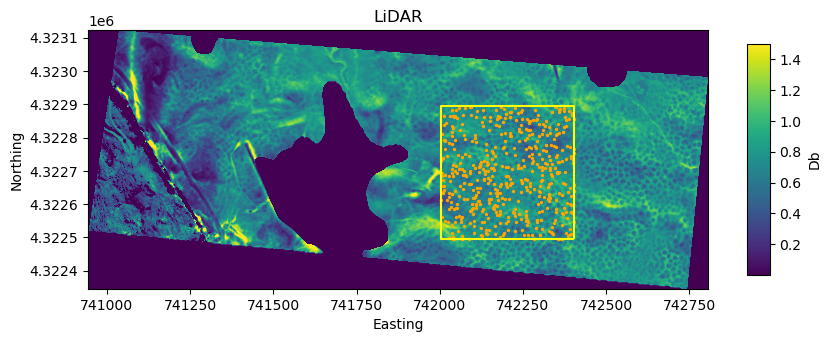

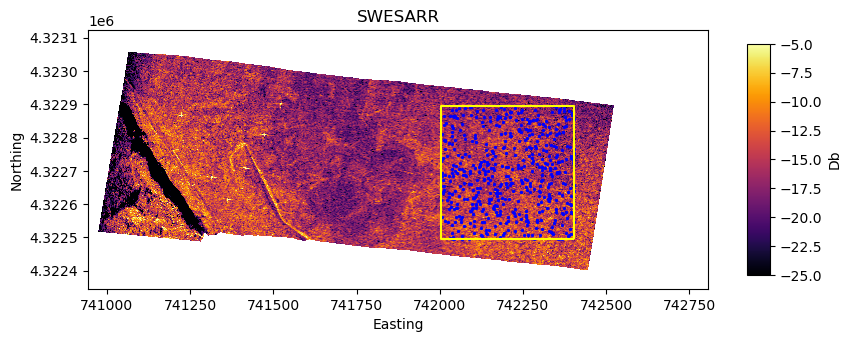

In [25]:
##Plot
## LiDAR
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the raster data
image = rasterio.plot.show(LiDAR_np, transform=LiDAR_transform, ax=ax, cmap='viridis', vmin=0.0001, vmax=1.5)

# Add the colorbar
cbar = fig.colorbar(image.get_images()[0], ax=ax, orientation='vertical', shrink=0.3, aspect=10)
cbar.set_label('Db')  # Set a label for the color bar

# Set the title and labels
ax.set_title('LiDAR')
ax.set_ylabel('Northing')
ax.set_xlabel('Easting')

# Plot the boundaries and points
gdf_square.boundary.plot(ax=ax, color='yellow')
gdf_points.plot(ax=ax, color='orange', markersize=2)

# Display the plot
plt.show()

######################
##SWESARR
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the raster data
image = rasterio.plot.show(SWESARR_np, transform=SWESARR_transform, ax=ax, cmap='inferno', vmin=-25, vmax=-5)

# Add the colorbar
cbar = fig.colorbar(image.get_images()[0], ax=ax, orientation='vertical', shrink=0.3, aspect=10)
cbar.set_label('Db')  # Set a label for the color bar

# Set the title and labels
ax.set_title('SWESARR')
ax.set_ylabel('Northing')
ax.set_xlabel('Easting')

# Plot the boundaries and points
gdf_square.boundary.plot(ax=ax, color='yellow')
gdf_points.plot(ax=ax, color='blue', markersize=2)

# Display the plot
plt.show()


#### Now, we'll extract raster values at these points. 